# Data structuring and NoSQL databases' Project

### Plan :
1. Load every datasets
2. Showing inconsistencies
3. Correcting/Cleaning everything with pandas
4. Putting everything in MongoDB
5. Selects, operations and showing graphs & insights 

In [1]:
# Importing every packet we'll need
import math as ma
from datetime import datetime, timedelta
import numpy as np

import pandas as pd
from pandas.io.json import json_normalize

import pymongo
from pymongo import MongoClient

#### 1. Load every datasets

In [2]:
# Found Objects
foundObjects = pd.read_csv("foundObjects.csv", delimiter = ";", encoding="utf-8")
# Returned Objects
#lostObjects = pd.read_csv("lostObjects.csv", delimiter = ";", encoding="utf-8")
lostObjects = pd.read_json("lostObjects.json")
# Attendace in train stations (2014, 2015, 2016)
attendance = pd.read_json("attendance.json")
# Weather of Paris, hour by hour (year : 2017)
weather = pd.read_csv("parisWeather2017.csv", delimiter = ",", encoding="utf-8")
# Station list
stationList = pd.DataFrame(pd.read_csv("station_list.csv", delimiter =";",encoding="utf-8") )
# List of station with wireless
stationWireless = pd.read_json("stationWireless.json")

In [3]:
#Renaming columns to make them shorter / make them standardized
lostObjects = pd.DataFrame.from_dict(json_normalize(lostObjects["fields"]), orient='columns')
lostObjects.rename(index=str, columns = {  "gc_obo_type_c":"object_type",\
                                            "gc_obo_nature_c":"object_nature",\
                                            "gc_obo_nom_recordtype_sc_c":"recording_type",\
                                            "gc_obo_gare_origine_r_name":"station",\
                                            "gc_obo_gare_origine_r_code_uic_c":"uic_code"}, inplace = True)

foundObjects.rename(index=str, columns = { "Date":"date",\
                                           "Date et heure de restitution":"restitution_date",\
                                           "Gare":"station",\
                                           "Code UIC":"uic_code",\
                                           "Nature d'objets":"object_nature",\
                                           "Type d'objets":"object_type",\
                                           "Type d'enregistrement":"recording_type"}, inplace = True)

stationList = stationList[["CODE_UIC","LIBELLE_GARE","CODE_LIGNE","COMMUNE","DEPARTEMENT","coordonnees_geographiques"]]\
                .rename(index=str, columns={"CODE_UIC":"uic_code","LIBELLE_GARE":"station_name","CODE_LIGNE":"line_code","COMMUNE":"city","DEPARTEMENT":"department","coordonnees_geographiques":"gps_coordinates"})


#### 2. Showing some of the inconsistencies

In [4]:
# Lot of Not Available values
print("Lines with Na in foundObjects :", foundObjects["date"].count() - foundObjects.dropna()["date"].count())
print("Lines with Na in returnedObjects :", lostObjects["date"].count() - lostObjects.dropna()["date"].count())

Lines with Na in foundObjects : 350310
Lines with Na in returnedObjects : 607764


In [5]:
# Same categories under different names (example with foundObjects)
print(lostObjects["object_type"].sort_values(ascending = True).unique())

['Appareil Ã©lectroniques, informatiques, appareils photo'
 'Appareils Ã©lectroniques, informatiques, appareils photo'
 'Appareils électroniques, informatiques, appareils photo'
 "Articles d'enfants, de puériculture"
 'Articles de sport, loisirs, camping' 'Articles médicaux'
 'Bagagerie: sacs, valises, cartables' 'Bijoux, montres'
 'Clés, porte-clés, badge magnétique' 'Divers' 'Instruments de musique'
 'Keys, keyholders, magnetic badges' 'Livres, articles de papéterie'
 'Optique' 'Parapluies' "Pièces d'identités et papiers personnels"
 'Porte-monnaie / portefeuille, argent, titres'
 'Vélos, trotinettes, accessoires 2 roues'
 'Vélos, trottinettes, accessoires 2 roues' 'Vêtements, chaussures']


In [6]:
# Read json doesn't read properly the file (.json)
attendance.head(1)

,datasetid,fields,record_timestamp,recordid
0,frequentation-gares,"{'voyageurs_2016': 53644, 'voyageurs_2015': 60...",2017-09-25T15:03:18+02:00,ebd19757d3cbb5d2af35e94796ac5d5f75de27d5


#### 3.Correcting / Cleaning everything with pandas

In [7]:
# Lost Objects

# Correcting categories names problem
lostObjects.replace({ "objects_type" : {'Appareil Ã©lectroniques, informatiques, appareils photo':"Appareils électroniques, informatiques, appareils photo",\
                                        "Vélos, trotinettes, accessoires 2 roues":"Vélos, trottinettes, accessoires 2 roues",\
                                        "Keys, keyholders, magnetic badges":"Clés, porte-clés, badge magnétique"} }\
                         ,regex = True,inplace = True)
# Changing Date (string with timezone) to Datetime
lostObjects['date'] =  pd.to_datetime(lostObjects['date'])

# Dropping all lines with no uic_code (no station associated)
# lostObjects.dropna(subset=["uic_code"], inplace=True)

# Casting uic_code to int instead of float

#lostObjects["uic_code"] = 
lostObjects["uic_code"].apply(lambda x : int(x) if (not ma.isnan(float(x))) else x)

lostObjects["object_type"].unique()

array(['Appareils électroniques, informatiques, appareils photo',
       'Porte-monnaie / portefeuille, argent, titres',
       'Vêtements, chaussures', 'Bagagerie: sacs, valises, cartables',
       'Clés, porte-clés, badge magnétique',
       "Articles d'enfants, de puériculture",
       "Pièces d'identités et papiers personnels",
       'Livres, articles de papéterie', 'Bijoux, montres', 'Divers',
       'Articles de sport, loisirs, camping', 'Optique',
       'Articles médicaux', 'Vélos, trottinettes, accessoires 2 roues',
       'Parapluies', 'Instruments de musique',
       'Keys, keyholders, magnetic badges',
       'Appareil Ã©lectroniques, informatiques, appareils photo',
       'Appareils Ã©lectroniques, informatiques, appareils photo',
       'Vélos, trotinettes, accessoires 2 roues'], dtype=object)

In [8]:
#Station List

#Adding wireless in the columns

stationWireless = pd.DataFrame.from_dict(json_normalize(stationWireless["fields"]), orient='columns')\
                    .rename(index=str, columns={"uic":"uic_code"})
# Fixing inconsistent UIC Code format problem (by adding 87 front of attendance's UIC Code)
stationWireless["uic_code"] = stationWireless["uic_code"].apply(lambda x: int("87"+str(x)))
# Merging both, filling the ones not matched with Non (we just guess that if they had it, it would be on it)
stationList = stationList.merge(stationWireless[["uic_code","service_wifi"]], how="outer", on="uic_code").fillna('Non')

In [9]:
# Attendance

# Extending fields in multiple columns
attendance = pd.DataFrame.from_dict(json_normalize(attendance["fields"]), orient='columns')
attendance.rename(index = str, columns = {  "code_postal":"zip_code",\
                                            "code_uic":"uic_code",\
                                            "nom_gare":"station",\
                                            "segmentation_decret":"category",\
                                            "volume_total_d_usagers_2014_voyageurs_non_voyageurs":"total_2014",\
                                            "volume_total_d_usagers_2015_voyageurs_non_voyageurs":"total_2015",\
                                            "volume_total_d_usagers_2016_voyageurs_non_voyageurs":"total_2016",\
                                            "voyageurs_2014":"2014",\
                                            "voyageurs_2015":"2015",\
                                            "voyageurs_2016":"2016"}, inplace = True)
# Fixing inconsistent UIC Code format problem (by adding 87 front of attendance's UIC Code)
attendance["uic_code"] = attendance["uic_code"].apply(lambda x: int("87"+str(x)))

# We need one line per year & city instead of one line for 3 years per city
attendance = pd.melt(attendance, id_vars=["station","zip_code","uic_code","category"],var_name='type').dropna().sort_values(by="zip_code")

# We transfer zip code & category in stationList collection (don't need to have zipcode eache year)
stationList = stationList.merge(attendance[["uic_code", "zip_code", "category"]], how='inner', on="uic_code")
#Then keep the remaining parts
attendance = attendance[["uic_code", "type","value"]]

In [10]:
# Found Objects

# Changing Date (string with timezone) to Datetime
#Goal : being able to use accessors such as dt.date to extract date (without time)
foundObjects['date'] =  pd.to_datetime(foundObjects['date'])
foundObjects['restitution_date'] =  pd.to_datetime(foundObjects['restitution_date'])

# Dropping all lines with no uic_code (no station associated)
foundObjects.dropna(subset=["uic_code"], inplace=True)
# Casting uic_code to int instead of float
foundObjects["uic_code"] = foundObjects["uic_code"].apply(lambda x : int(x))

#Filling missing ones with Na
foundObjects["restitution_date"].fillna('Na', inplace = True)
foundObjects.head(5)

,date,restitution_date,station,uic_code,object_nature,object_type,recording_type
0,2018-01-23 13:33:43,Na,Bourges,87576207,Autres divers (préciser),Divers,Objet trouvé
1,2018-01-23 13:34:38,2018-01-23 13:54:28,Paris Montparnasse,87391003,"Valise, sac sur roulettes","Bagagerie: sacs, valises, cartables",Objet trouvé
2,2018-01-23 13:53:49,Na,Marseille Saint-Charles,87751008,"Valise, sac sur roulettes","Bagagerie: sacs, valises, cartables",Objet trouvé
3,2018-01-23 13:54:22,2018-03-05 13:59:46,Valence,87761007,Sac à dos,"Bagagerie: sacs, valises, cartables",Objet trouvé
4,2018-01-23 14:01:05,2018-01-31 08:40:52,Chartres,87394007,"Clés, porte-clés","Clés, porte-clés, badge magnétique",Objet trouvé


In [11]:
# Weather (in Paris for the example)

weather = pd.concat([
                            pd.DataFrame(["Paris"] * len(weather), columns=["city"])
                           ,pd.to_datetime(weather["DATE"])
                           ,weather["TMP"].apply(lambda x: float( x.replace(',','.') )/10)
                           ,pd.DataFrame(weather["MW1"].apply(lambda x: str(x)).str.split(',',1).tolist(),
                                                   columns = ['weather_description','weather_quality_code'])
                           ,pd.DataFrame(weather["AA1"].str.split(',',4).tolist(),
                                                   columns = ['rain_period_quantity','rain_depth_dimension','rain_condition_code','rain_quality_code'])
                          ]
                          , axis = 1).rename(index=str, columns = { "DATE":"date", "TMP":"temperature" })

# Dropping rows with quality equals to none
weather = weather.dropna()
# Cleaning 
weather = weather.loc[weather["temperature"] != 999.99]

weather.head(1)

,city,date,temperature,weather_description,weather_quality_code,rain_period_quantity,rain_depth_dimension,rain_condition_code,rain_quality_code
0,Paris,2017-01-01,-3.91,00,1,03,0000,9,1


#### 4.Putting everything in MongoDB

In [12]:
#Opening connection with MongoDB

client = MongoClient()
myclient = pymongo.MongoClient("mongodb://127.0.0.1:27017")
mydb = myclient["DBProject"]

In [13]:
#Add documents in several collections

mydb["attendance"].insert_many(attendance.to_dict("records"))
mydb["foundObjects"].insert_many(foundObjects.to_dict("records"))
mydb["lostObjects"].insert_many(lostObjects.to_dict("records"))
mydb["weather"].insert_many(weather.to_dict("records"))
mydb["stationList"].insert_many(stationList.to_dict("records"))

That leads us to this "schema"
<img src="dbmodel.PNG" alt="Drawing" style="width: 600px;height: 400px;"/>

#### 5. Selects, operations and showing graphs & insights 

###### Basic queries

In [14]:
# Most forgotten objects
pd.DataFrame(list(mydb["foundObjects"].aggregate( [{"$group":{"_id":"$object_type","count":{"$sum":1}}}] )))\
            .plot.barh(x = "_id", y = "count", legend = False)

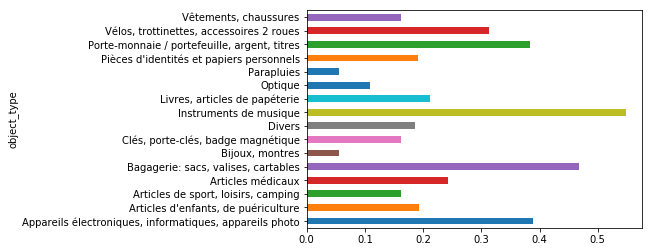

In [15]:
# Most returned objects (%ages per type) 
restitutionDataFrame = pd.DataFrame(list(mydb["foundObjects"].find({},\
                                                                   {"_id":0, "date":1, "object_type":1,"restitution_date":1})))
restitutionDataFrame.loc[restitutionDataFrame["restitution_date"] != "Na"].groupby(["object_type"])["date"].count()\
    .divide(restitutionDataFrame.groupby(["object_type"])["date"].count())\
    .plot.barh()

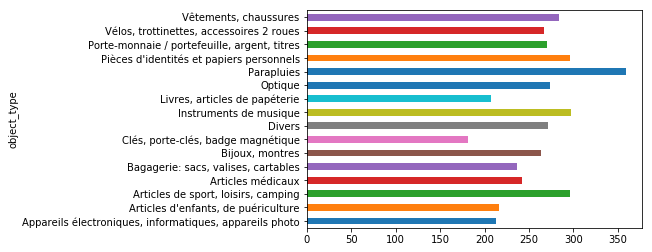

In [16]:
# Average time between the moment we find the object and the moment we give it back (per type)
avgRestitutionTime = pd.DataFrame(list(mydb["foundObjects"].find({"restitution_date" : {"$ne":"Na"}},\
                                                                 {"_id":0, "date":1, "object_type":1,"restitution_date":1})))
#Delta between find and return (in s)
avgRestitutionTime["delta"] = (avgRestitutionTime["restitution_date"] - avgRestitutionTime["date"]).dt.total_seconds()
#Doing the mean then dividing by 3600 to make it in hours
avgRestitutionTime.groupby(["object_type"])["delta"].mean().apply(lambda x: x/3600).plot.barh()

###### Joining with attendance

In [17]:
# How much objects lost regarding attendance
attendanceLostObjects = pd.DataFrame(list(mydb["foundObjects"].aggregate([
    {"$match":{"date" :{"$gte":pd.to_datetime("2016-01-01 00:00:00"), "$lte":pd.to_datetime("2016-12-31 00:00:00")}}}
    ,{"$group":{"_id":"$uic_code","count":{"$sum":1}}}
    ,{"$lookup":{"from":"attendance"
                ,"let":{ "uic":"$_id"}
                ,"pipeline":[
                    {"$match":
                        {"$expr":
                            {"$and":[
                                {"$eq":["$type","2016"]},
                                {"$eq":["$uic_code","$$uic"]}
                            ]}
                        }
                    }
                ]
                ,"as":"join"
                }
     }
    ,{"$replaceRoot": { "newRoot": { "$mergeObjects": [ { "$arrayElemAt": [ "$join", 0 ] }, "$$ROOT" ] } }}
    ,{ "$project": { "join": 0, "uic_code":0 } }
])))
attendanceLostObjects.head(5)

,_id,count,type,value
0,87725689,6,2016,1158505.0
1,87382655,11,2016,6193800.0
2,87444711,4,2016,371714.0
3,87745679,26,2016,161881.0
4,87215012,14,2016,702899.0


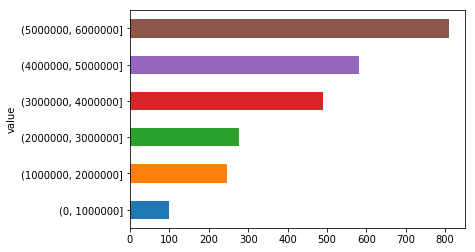

In [18]:
# Mean of lost objects number regrouped by classes of attendance
# > 5 Because otherwise it wouldn't be representative enough
attendanceLostObjects.groupby(pd.cut(attendanceLostObjects["value"], np.arange(0,135000000,1000000)))["count"].mean()\
[attendanceLostObjects.groupby(pd.cut(attendanceLostObjects["value"], np.arange(0,135000000,1000000)))["count"].count() > 5]\
.plot.barh()

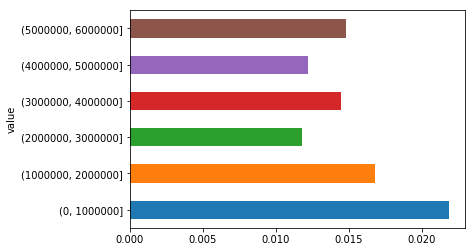

In [19]:
# Average lost objects per person doesn't seem to depend on the station's attendance
attendanceLostObjects["ratio"] = (attendanceLostObjects["count"].divide(attendanceLostObjects["value"])*100)
attendanceLostObjects.groupby(pd.cut(attendanceLostObjects["value"], np.arange(0,135000000,1000000)))["ratio"].mean()\
    [attendanceLostObjects.groupby(pd.cut(attendanceLostObjects["value"], np.arange(0,135000000,1000000)))["ratio"].count() > 5]\
    .plot.barh()

###### Joining with weather

In [20]:
# Comparison of found objects amount with weather in Paris 2017 !

#Weather in Paris in 2017
parisWeather = pd.DataFrame(list(mydb["weather"].find(
                                    {"$and": 
                                     [
                                         {"city" : {"$eq":"Paris"}},
                                         {"date" : {"$gte":pd.to_datetime("2017-01-01 00:00:00"), "$lte":pd.to_datetime("2017-12-31 00:00:00")}} 
                                     ]
                                    },
                                    {"_id":0, "rain_condition_code":0,"rain_depth_dimension":0,"rain_period_quantity":0,"rain_quality_code":0})))

parisWeather["weather_description"] = parisWeather["weather_description"].astype(np.int64)

# Railway stations in Paris
parisStationList = pd.DataFrame(list(mydb["stationList"].find(
    {"department" :{"$eq":"Paris"} }, {"_id":0, "uic_code":1}
))).drop_duplicates() #Because one station may have more than one platform

# Found objects 
foundObjects2017 = pd.DataFrame(list(mydb["foundObjects"].find(
    {"date" :{"$gte":pd.to_datetime("2017-01-01 00:00:00"), "$lte":pd.to_datetime("2017-12-31 00:00:00")}}
    ,{"_id":0,"station":0,"recording_type":0}    
)))

comparisonFoundObjectWeatherParis = foundObjects2017.merge(parisStationList, how = "inner", on = ["uic_code"]).set_index("date")

In [21]:
# Comparison of found objects amount when it's not raining or not

#   Different steps :
# Selecting only umbrellas
# Grouping by Hours 
# Joining with weather 
# Counting them by weather description

rainCount = comparisonFoundObjectWeatherParis.loc[comparisonFoundObjectWeatherParis["object_type"] == "Parapluies"]\
                                 .resample("60Min")["object_nature"]\
                                 .count()\
                                 .rename("count")\
                                 .reset_index()\
                                 .merge(parisWeather, how = "inner", on = ["date"])\
                                 .groupby("weather_description")["count"].sum()\
                                 .reset_index()\
                                 .astype(np.int64)


totalLost = rainCount["count"].sum()
lostDuringRain = rainCount.loc[(rainCount["weather_description"] >= 50)]["count"].sum()

print("Percentage of lost umbrella during rain : ", lostDuringRain*100/totalLost, "%")
print("Number of umbrellas lost per hour when it doesn't rain :",(totalLost-lostDuringRain)/parisWeather.loc[(parisWeather["weather_description"] < 50)]["date"].count())
print("Number of umbrellas lost per hour when it rains :",lostDuringRain/parisWeather.loc[(parisWeather["weather_description"] >= 50)]["date"].count())

Percentage of lost umbrella during rain :  8.636363636363637 %
Number of umbrellas lost per hour when it doesn't rain : 0.025096766138094643
Number of umbrellas lost per hour when it rains : 0.030744336569579287


In [22]:
# Let's see what's happening with the other items
#Same method !

rainCount = comparisonFoundObjectWeatherParis.loc[comparisonFoundObjectWeatherParis["object_type"] != "Parapluies"]\
                                 .resample("60Min")["object_nature"]\
                                 .count()\
                                 .rename("count")\
                                 .reset_index()\
                                 .merge(parisWeather, how = "inner", on = ["date"])\
                                 .groupby("weather_description")["count"].sum()\
                                 .reset_index()\
                                 .astype(np.int64)


totalLost = rainCount["count"].sum()
lostDuringRain = rainCount.loc[(rainCount["weather_description"] >= 50)]["count"].sum()

print("Percentage of lost objects (except umbrellas) during rain : ", lostDuringRain*100/totalLost, "%")
print("Number of objects (except umbrellas) lost per hour when it doesn't rain :",(totalLost-lostDuringRain)/parisWeather.loc[(parisWeather["weather_description"] < 50)]["date"].count())
print("Number of objects (except umbrellas) lost per hour when it rains :",lostDuringRain/parisWeather.loc[(parisWeather["weather_description"] >= 50)]["date"].count())

Percentage of lost objects (except umbrellas) during rain :  6.760372159884998 %
Number of objects (except umbrellas) lost per hour when it doesn't rain : 2.9154700961418403
Number of objects (except umbrellas) lost per hour when it rains : 2.7394822006472492


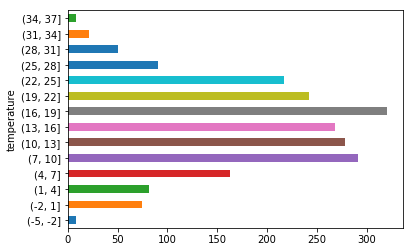

In [23]:
# Let's see the temperatures now !
#Focusing on clothes
temperatureCount = comparisonFoundObjectWeatherParis.loc[comparisonFoundObjectWeatherParis["object_type"] == "Vêtements, chaussures"]\
                                 .resample("60Min")["object_nature"]\
                                 .count()\
                                 .rename("count")\
                                 .reset_index()\
                                 .merge(parisWeather, how = "inner", on = ["date"])\

#Nb of clothes lost per hour depending on temperature intervals 
temperatureCount.groupby(pd.cut(temperatureCount["temperature"], np.arange(-5,40,3)))["count"].sum().plot.barh()

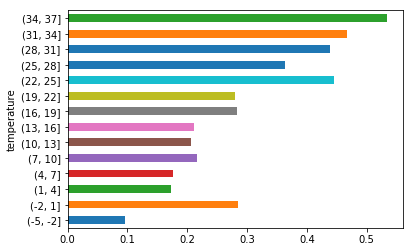

In [24]:
#Nb of clothes lost per hour depending on temperature intervals 
temperatureCount.groupby(pd.cut(temperatureCount["temperature"], np.arange(-5,40,3)))["count"].sum().divide(
parisWeather.groupby(pd.cut(parisWeather["temperature"], np.arange(-5,40,3)))["date"].count()).plot.barh()

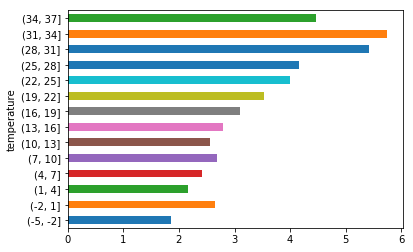

In [25]:
# Let's see what's happening with the other items
#Same method !
temperatureCount = comparisonFoundObjectWeatherParis\
                                 .resample("60Min")["object_nature"]\
                                 .count()\
                                 .rename("count")\
                                 .reset_index()\
                                 .merge(parisWeather, how = "inner", on = ["date"])\


#Nb of objects lost per hour depending on temperature intervals 
temperatureCount.groupby(pd.cut(temperatureCount["temperature"], np.arange(-5,40,3)))["count"].sum().divide(
parisWeather.groupby(pd.cut(parisWeather["temperature"], np.arange(-5,40,3)))["date"].count()).plot.barh()

###### Finding inconsistencies on Found Objects vs Lost Objects

In [31]:
lostObjects = pd.DataFrame(list(mydb["lostObjects"].find({})))
foundObjects = pd.DataFrame(list(mydb["foundObjects"].find({})))
    
#Record difference between lost and declared
print("Difference between declared lost objects and found ones:", len(lostObjects) - len(foundObjects))

Difference between declared lost objects and found ones: 385019


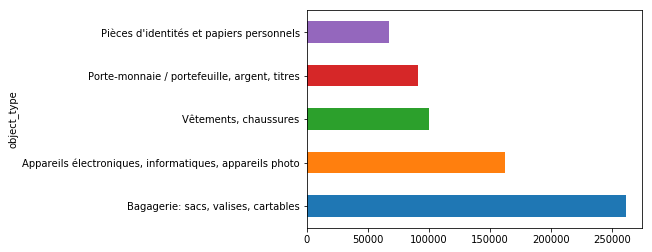

In [32]:
# Top 5 categories of objects declared as lost
lostObjects.groupby("object_type")["date"].count().sort_values(ascending = False).head(5).plot.barh()

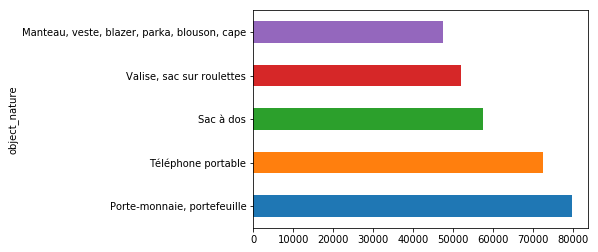

In [33]:
# Top 5 nature of objects declared as lost 
lostObjects.groupby("object_nature")["date"].count().sort_values(ascending=False).head(5).plot.barh()

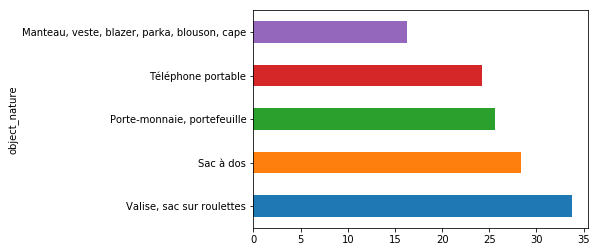

In [34]:
#
#Top 5 label of declared as lost objects
topDeclaredObjectNature = lostObjects.groupby("object_nature")["date"].count().sort_values(ascending=False).head(5).index

(foundObjects.loc[(foundObjects["object_nature"].isin(topDeclaredObjectNature)) & (foundObjects["restitution_date"] != "Na")].groupby("object_nature")["date"].count()*100).divide(
lostObjects.loc[lostObjects["object_nature"].isin(topDeclaredObjectNature)].groupby("object_nature")["date"].count()).sort_values(ascending =False).plot.barh()